# 02 · Codificación offline a HDF5

Este notebook convierte un split CSV (`train/val/test`) a un __HDF5__ con codificación __rate/latency/raw__ para acelerar entrenamientos (evita encode on-the-fly).

__Cómo encaja en el TFM__: permite __benchmarks__ consistentes y comparables de entrenamiento, con tiempos más estables.

__Parámetros y rutas__

Definimos qué split convertir y con qué __encoder__. La ruta de salida incluye `T/GAIN/SIZE` para trazabilidad.

In [4]:
# imports & params

from pathlib import Path
import sys
import pandas as pd  # <-- corregido

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.prep.encode_offline import encode_csv_to_h5

RUNS   = ["circuito1", "circuito2"]
SPLITS = ["train", "val", "test"]      # vamos a generar los 3 por recorrido

ENCODER = "rate"                       # "rate" | "latency" | "raw"
T       = 20
GAIN    = 0.5                          # solo aplica a 'rate'
SIZE    = (160, 80)                    # (W, H)
TO_GRAY = True
SEED    = 42

RAW_ROOT  = ROOT / "data" / "raw" / "udacity"
PROC_ROOT = ROOT / "data" / "processed"


__Ejecutar codificación__

Llamamos a `encode_csv_to_h5`. Si el fichero existe, se sobreescribe.

In [5]:
# Generar H5 para todos los RUNS x SPLITS (usa el formato "oficial" v2)

SAMPLE_OUT = None  # guardaremos aquí el primer H5 generado para inspección

for run in RUNS:
    base   = RAW_ROOT / run
    outdir = PROC_ROOT / run
    outdir.mkdir(parents=True, exist_ok=True)

    # Comprobaciones por recorrido
    assert base.exists(), f"No existe carpeta de imágenes: {base}"

    for split in SPLITS:
        csv = outdir / f"{split}.csv"
        assert csv.exists(), f"No existe CSV: {csv} (ejecuta antes el prep de splits)"

        out = outdir / f"{split}_{ENCODER}_T{T}_gain{GAIN if ENCODER=='rate' else 0}_" \
                       f"{'gray' if TO_GRAY else 'rgb'}_{SIZE[0]}x{SIZE[1]}.h5"

        encode_csv_to_h5(
            csv_df_or_path=csv, base_dir=base, out_path=out,
            encoder=ENCODER, T=T, gain=GAIN, size_wh=SIZE,
            to_gray=TO_GRAY, seed=SEED
        )
        print("OK:", out)

        if SAMPLE_OUT is None:
            SAMPLE_OUT = out  # nos quedamos con el primero para la celda de inspección


OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T20_gain0.5_gray_160x80.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/val_rate_T20_gain0.5_gray_160x80.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/test_rate_T20_gain0.5_gray_160x80.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/train_rate_T20_gain0.5_gray_160x80.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/val_rate_T20_gain0.5_gray_160x80.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/test_rate_T20_gain0.5_gray_160x80.h5


__Inspección rápida del HDF5 (opcional)__

Abrimos el `.h5` generado para:

- listar atributos del fichero (`T`, `gain`, `size`, etc.),
- revisar la estructura (grupo samples, `steering`, …),
- comprobar formas y dtypes,
- y visualizar una proyección simple (acumulado temporal) del primer ejemplo para verificar que los datos tienen sentido.

Atributos:
 - T: 20
 - channels: 1
 - encoder: rate
 - gain: 0.5
 - size_wh: [160  80]
 - to_gray: 1
 - version: 2
Datasets: ['filenames', 'spikes', 'steering']
spikes: (10468, 20, 80, 160) uint8 | steering: (10468,) float32


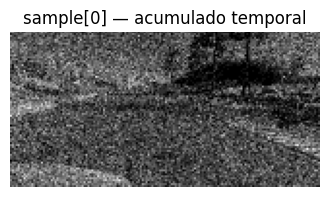

In [ ]:
# Inspección del H5 (formato oficial v2)
import h5py, numpy as np, matplotlib.pyplot as plt

assert SAMPLE_OUT is not None, "No se generó ningún H5 en la celda anterior."
print("Mostrando:", SAMPLE_OUT)

def _proj_img(x):
    # (T,H,W) -> acumula T; (T,C,H,W) -> acumula T y C
    if x.ndim == 2:
        return x
    if x.ndim == 3:
        return x.sum(axis=0)
    if x.ndim == 4:
        return x.sum(axis=(0,1))
    raise ValueError(x.shape)

with h5py.File(SAMPLE_OUT, "r") as h5:
    print("Atributos:")
    for k, v in h5.attrs.items():
        print(f" - {k}: {v}")
    print("Datasets:", list(h5.keys()))

    X = h5["spikes"]
    y = h5["steering"]
    print("spikes:", X.shape, X.dtype, "| steering:", y.shape, y.dtype)

    # primera muestra
    x0 = X[0]  # (T,H,W) o (T,C,H,W)
    acc = _proj_img(x0)

plt.figure(figsize=(4, 3))
plt.imshow(acc, cmap="gray")
plt.title("sample[0] — acumulado temporal")
plt.axis("off")
plt.show()
